In [1]:
import json
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Load the scaler parameters from JSON
with open('scalers_and_data/scaler_y_0_25eV.json', 'r') as f:
    scaler_params = json.load(f)

# Create a new MinMaxScaler instance and set its parameters
scaler_y = MinMaxScaler(feature_range=tuple(scaler_params['feature_range']))
scaler_y.min_ = np.array(scaler_params['min_'])
scaler_y.scale_ = np.array(scaler_params['scale_'])
scaler_y.data_min_ = np.array(scaler_params['data_min_'])
scaler_y.data_max_ = np.array(scaler_params['data_max_'])
scaler_y.data_range_ = np.array(scaler_params['data_range_'])

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

class DeepSet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepSet, self).__init__()
        self.rho = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        output = self.rho(x)
        return output

class InverseScaler(nn.Module):
    def __init__(self, feature_range, data_min, data_range):
        super(InverseScaler, self).__init__()
        feature_min, feature_max = feature_range
        self.a = data_range / (feature_max - feature_min)
        self.b = (-feature_min * self.a) + data_min
        # Convert to tensors and register as buffers
        self.register_buffer('a_tensor', torch.tensor(self.a, dtype=torch.float32))
        self.register_buffer('b_tensor', torch.tensor(self.b, dtype=torch.float32))
    
    def forward(self, x):
        return x * self.a_tensor + self.b_tensor

class DeepSetWithInverseScaling(nn.Module):
    def __init__(self, original_model, scaler_params):
        super(DeepSetWithInverseScaling, self).__init__()
        self.original_model = original_model
        feature_range = scaler_params['feature_range']
        data_min = scaler_params['data_min_'][0]
        data_range = scaler_params['data_range_'][0]
        self.inverse_scaler = InverseScaler(feature_range, data_min, data_range)
    
    def forward(self, x):
        scaled_output = self.original_model(x)
        inverse_scaled_output = self.inverse_scaler(scaled_output)
        return inverse_scaled_output

# Load OH_elements and p_dict_oh as in your original code
with open('helper_objects/OH_elements.json', 'r') as file:
    OH_elements = json.load(file)

total_N_elements = len(OH_elements)

with open('helper_objects/p_dict_oh.json', 'r') as file:
    p_dict_oh = json.load(file)

# Parameters
input_dim = len(p_dict_oh['H'])  # Dimension of each feature vector
hidden_dim = 512  # Hidden layer size
output_dim = 1  # Single value output (formation energy)

# Initialize the original model and load state
NN = DeepSet(input_dim, hidden_dim, output_dim).to(device)
model_path = 'models/NN.pth'
NN.load_state_dict(torch.load(model_path, map_location=device))
NN.eval()

# Prepare scaler parameters for inverse scaling
scaler_params_inverse = {
    'feature_range': scaler_y.feature_range,
    'data_min_': scaler_y.data_min_,
    'data_range_': scaler_y.data_range_
}

# Create the combined NN model
combined_NN = DeepSetWithInverseScaling(NN, scaler_params_inverse).to(device)
combined_NN.eval()

Using device: cpu


DeepSetWithInverseScaling(
  (original_model): DeepSet(
    (rho): Sequential(
      (0): Linear(in_features=118, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): Tanh()
      (6): Linear(in_features=512, out_features=1, bias=True)
    )
  )
  (inverse_scaler): InverseScaler()
)

In [2]:
import json
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn

# ----------------------------
# Load target scaler (as before)
# ----------------------------
with open('scalers_and_data/scaler_y_0_025eV.json', 'r') as f:
    scaler_params = json.load(f)

scaler_y = MinMaxScaler(feature_range=tuple(scaler_params['feature_range']))
scaler_y.min_        = np.array(scaler_params['min_'])
scaler_y.scale_      = np.array(scaler_params['scale_'])
scaler_y.data_min_   = np.array(scaler_params['data_min_'])
scaler_y.data_max_   = np.array(scaler_params['data_max_'])
scaler_y.data_range_ = np.array(scaler_params['data_range_'])

# ----------------------------
# Device
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ----------------------------
# Inverse scaler (same API)
# ----------------------------
class InverseScaler(nn.Module):
    def __init__(self, feature_range, data_min, data_range):
        super().__init__()
        feature_min, feature_max = feature_range
        a = data_range / (feature_max - feature_min)
        b = (-feature_min * a) + data_min
        self.register_buffer('a_tensor', torch.tensor(a, dtype=torch.float32))
        self.register_buffer('b_tensor', torch.tensor(b, dtype=torch.float32))
    def forward(self, x):
        return x * self.a_tensor + self.b_tensor

# ----------------------------
# Max-Affine predictor (hard max)
# y(x) = max_j (w_j^T x + b_j)
# ----------------------------
class MaxAffine(nn.Module):
    def __init__(self, W, b):
        super().__init__()
        # W: [K, d], b: [1]
        # Store as Parameters for convenience (eval mode by default)
        self.W = nn.Parameter(W, requires_grad=False)
        self.b = nn.Parameter(b, requires_grad=False)
    def forward(self, x):
        # x: [N, d] (same feature layout you already use)
        z = x @ self.W.t() + self.b[:, None]   # [N, K]
        y = z.max(dim=1).values.view(-1, 1)    # [N, 1]
        return y

# ----------------------------
# Wrapper to match your "combined_model" name
# ----------------------------
class DeepSetWithInverseScaling(nn.Module):
    # Keep this class name to avoid changing downstream code
    def __init__(self, original_model, scaler_params):
        super().__init__()
        self.original_model = original_model
        feature_range = scaler_params['feature_range']
        data_min = scaler_params['data_min_'][0]
        data_range = scaler_params['data_range_'][0]
        self.inverse_scaler = InverseScaler(feature_range, data_min, data_range)
    def forward(self, x):
        scaled_output = self.original_model(x)          # standardized [0,1] target space
        inverse_scaled_output = self.inverse_scaler(scaled_output)  # back to eV
        return inverse_scaled_output

# ----------------------------
# Load OH_elements / p_dict_oh (as before)
# ----------------------------
with open('helper_objects/OH_elements.json', 'r') as file:
    OH_elements = json.load(file)
total_N_elements = len(OH_elements)

with open('helper_objects/p_dict_oh.json', 'r') as file:
    p_dict_oh = json.load(file)

input_dim = len(p_dict_oh['H'])   # feature dimension

# ----------------------------
# Load max-affine weights
# Expecting a .pt saved as: torch.save({'W': tensor[K,d], 'b': tensor[K]}, path)
# ----------------------------
max_affine_path = 'models/MA.pt'  # <-- set this
ckpt = torch.load(max_affine_path, map_location=device)

W = ckpt['W'].float().to(device)   # [K, d]
b = ckpt['b'].float().to(device)   # [K]

# Sanity check on dimensions
assert W.dim() == 2 and b.dim() == 1, "Checkpoint must contain W[K,d] and b[1]"
assert W.shape[1] == input_dim, f"Feature dim mismatch: W has d={W.shape[1]} but input_dim={input_dim}"

# ----------------------------
# Build models
# ----------------------------
# Max-affine predictor in standardized target space
MA = MaxAffine(W, b).to(device)
MA.eval()

# Prepare scaler params for inverse (same structure you used)
scaler_params_inverse = {
    'feature_range': scaler_y.feature_range,
    'data_min_': scaler_y.data_min_,
    'data_range_': scaler_y.data_range_
}

# Expose the SAME NAME used elsewhere in your code:
combined_MA = DeepSetWithInverseScaling(MA, scaler_params_inverse).to(device)
combined_MA.eval()

Using device: cpu


DeepSetWithInverseScaling(
  (original_model): MaxAffine()
  (inverse_scaler): InverseScaler()
)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


0.09226718246936799


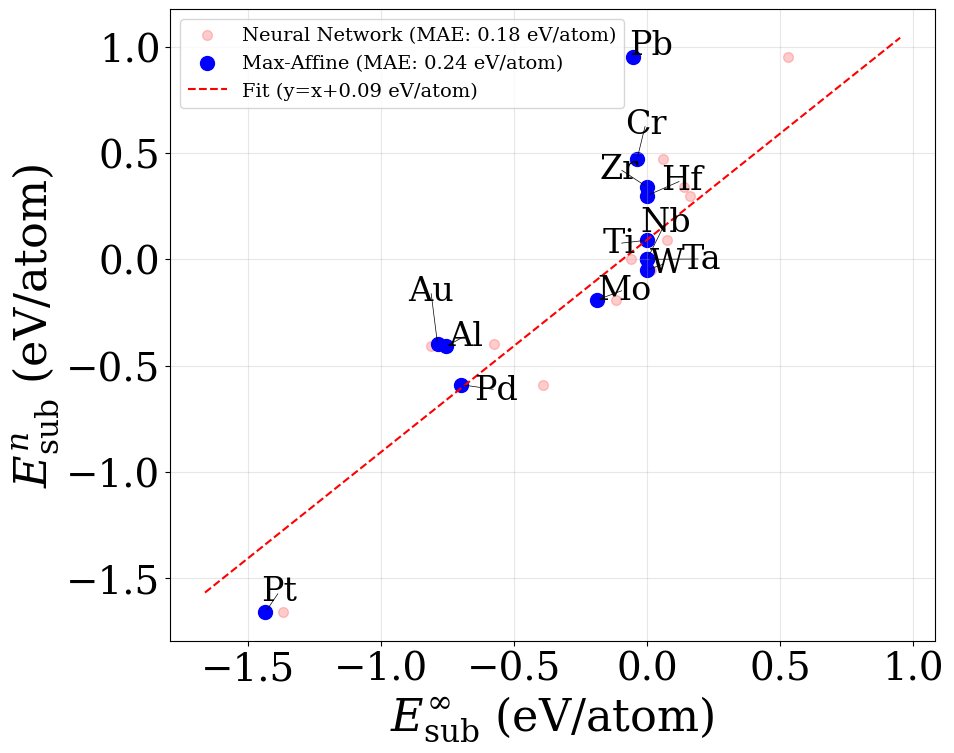

In [3]:
# Get substitutional energies of materials

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text  # Make sure to install adjustText via pip if you haven't already

# Set global publication-quality settings
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

rainbow = [
    "#d94c4c",  # red
    "#63c965",  # green
    "#7465d8",  # indigo
    "#b45de9",  # violet
    "#f6db4a",  # yellow
    "#469be8",  # blue
    "#f49b25",  # orange
]

# Convert the dictionary of NumPy arrays/lists into a dictionary of Torch tensors
p_dict_oh_t = {
    key: torch.tensor(value, dtype=torch.float32, device=device)
    for key, value in p_dict_oh.items()
}


def func(x, impurity, model, p_dict_oh_t):

    x_t = torch.tensor(x, dtype=torch.float32, device=device, requires_grad=True)

    E = model(x_t)
    
    grad_x = torch.autograd.grad(
        outputs=E,
        inputs=x_t,
        create_graph=False,
        retain_graph=False
    )[0]

    x_imp = p_dict_oh_t[impurity]

    res_t = ((x_imp - x_t) * grad_x).sum()

    return res_t.item()

def func_finite_diff(x0, x1, dx, model, p_dict_oh_t):
    """
    Computes:
       res = -dE/dImpurity + xfull . (dE/dxfull)
    but returns it as a *float* for the optimizer.

    Args:
        x (np.ndarray): shape (len(element_set),), the subset of parameters we optimize.
        impurity (string): element we substitute
        model (nn.Module): PyTorch model returning a scalar E.
        p_dict_oh_t (dict): e.g. {'O': one-hot Tensor, 'H': one-hot Tensor, ...}.

    Returns:
        float: The scalar value of res, detached from Torch.
    """
    # Convert x -> a Torch tensor for internal computation
    x_t0 = torch.tensor(x0, dtype=torch.float32, device=device, requires_grad=True)
    x_t1 = torch.tensor(x1, dtype=torch.float32, device=device, requires_grad=True)

    # 2) Forward pass -> E(xfull)  (should be a scalar)
    E0_pre = model(x_t0)
    E1_pre = model(x_t1)

    E0 = scaler_y.inverse_transform(E0_pre.detach().cpu().numpy().reshape(-1, 1))[0]
    E1 = scaler_y.inverse_transform(E1_pre.detach().cpu().numpy().reshape(-1, 1))[0]

    res_t = (E1 - E0) / dx

    # Return a Python float for the optimizer
    return res_t.item()

cris_elements = ['Nb', 'Al', 'Ti', 'Au', 'Pd', 'Pt', 'Ta', 'Zr', 'Hf', 'Pb', 'W', 'Mo', 'Cr']
ML_energies_NN = []
ML_energies_MA = []
for cris_el in cris_elements:
    dx = 0.5
    pure = 'Nb'
    impurity = cris_el
    x0 = np.array(p_dict_oh[pure])
    x1 = (1-dx) * np.array(p_dict_oh[pure]) + dx * np.array(p_dict_oh[impurity])
    # NN prediction
    finite_diff_contrib = func_finite_diff(x0, x1, dx, NN, p_dict_oh_t)
    epure = combined_NN(torch.tensor(p_dict_oh[pure]))[0].item()
    eimpure = combined_NN(torch.tensor(p_dict_oh[impurity]))[0].item()
    ML_energies_NN.append(epure-eimpure + finite_diff_contrib)
    # MA prediction
    finite_diff_contrib = func_finite_diff(x0, x1, dx, MA, p_dict_oh_t)
    epure = combined_MA(torch.tensor(p_dict_oh[pure]))[0].item()
    eimpure = combined_MA(torch.tensor(p_dict_oh[impurity]))[0].item()
    ML_energies_MA.append(epure-eimpure + finite_diff_contrib)

# Plot DFT vs Ml substitution energies

# DFT Data
DFT = [0, -0.41, 0.09, -0.4, -0.59, -1.66, 0, 0.34, 0.3, 0.95, -0.05, -0.19, 0.47]

# Compute MAE and add as a text box on the plot

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Compute intercept of best slope‑1 line
d_bar = np.mean(np.array(DFT) - np.array(ML_energies_NN))
print(d_bar)
mae_NN = np.mean(np.abs(ML_energies_NN + d_bar - (DFT)))
mae_MA = np.mean(np.abs(ML_energies_MA + d_bar - (DFT)))

# Plot points
scatter = ax.scatter(ML_energies_NN, DFT, color='red', s=50, alpha=0.2, label = f'Neural Network (MAE: {mae_NN:.2f} eV/atom)')
scatter = ax.scatter(ML_energies_MA, DFT, color='blue', s=100, label = f'Max-Affine (MAE: {mae_MA:.2f} eV/atom)')

# Create a list to store the text objects
texts = []
offset = 0.0
for dft, ml, element in zip(ML_energies_MA, DFT, cris_elements):
    txt = ax.text(dft+offset, ml+offset, element, fontsize=24, ha='left', va='bottom')
    texts.append(txt)

# Use adjust_text to automatically reposition the text labels to avoid overlapping
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
    force_points=12,    # strength of force from points
    force_text=10000,      # strength of force between texts
    expand_points=(500, 500),  # extra margin from points
    expand_text=(100, 100),    # extra margin from text boxes
    only_move={'points':'xy', 'text':'xy'},  # control movement directions
    lim=10000              # max number of iterations
)


# Range for plotting
xmin, xmax = min(np.array(DFT).min(), np.array(ML_energies_NN).min()), max(np.array(DFT).max(), np.array(ML_energies_NN).max())

# Plot the slope‑one best‑fit line
ax.plot([xmin, xmax], [xmin + d_bar, xmax + d_bar],
        color='red', linestyle='--', label=f'Fit (y=x+{d_bar:.2f} eV/atom)')


# Label axes and add grid
ax.set_ylabel(r'$E^{n}_{\mathrm{sub}}\ \mathrm{(eV/atom)}$', fontsize=32)
ax.set_xlabel(r'$E^{\infty}_{\mathrm{sub}}\ \mathrm{(eV/atom)}$', fontsize=32)
ax.grid(alpha=0.3)
ax.legend(fontsize=14)

# Set tick parameters for better visibility
ax.tick_params(axis='both', which='major', labelsize=28)
plt.savefig('plots/MA-substitution.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

1.2358656957626344


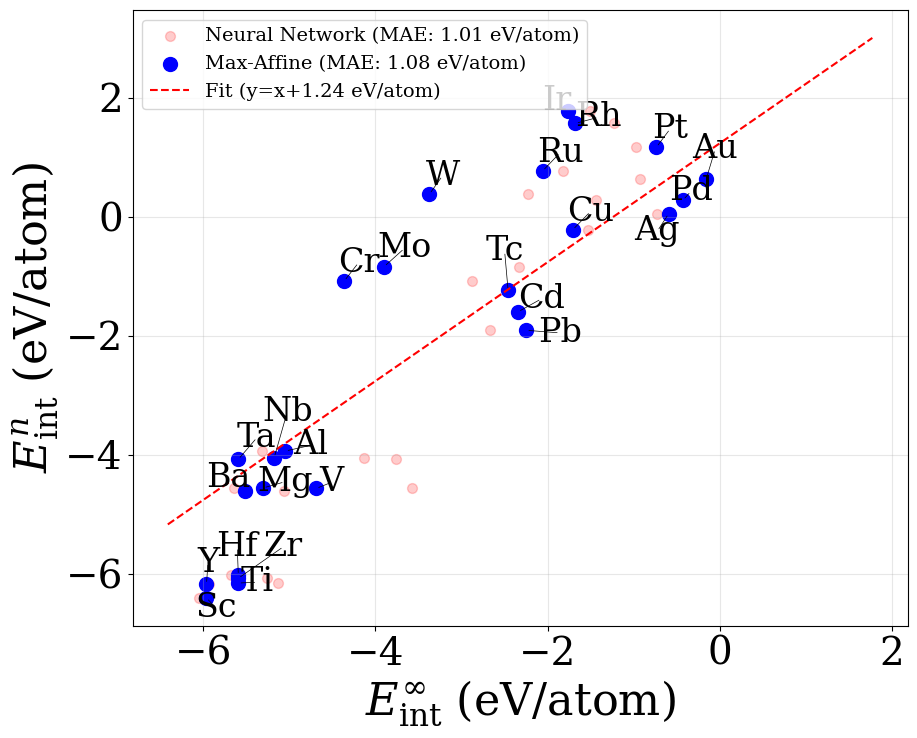

1.7512205161094667


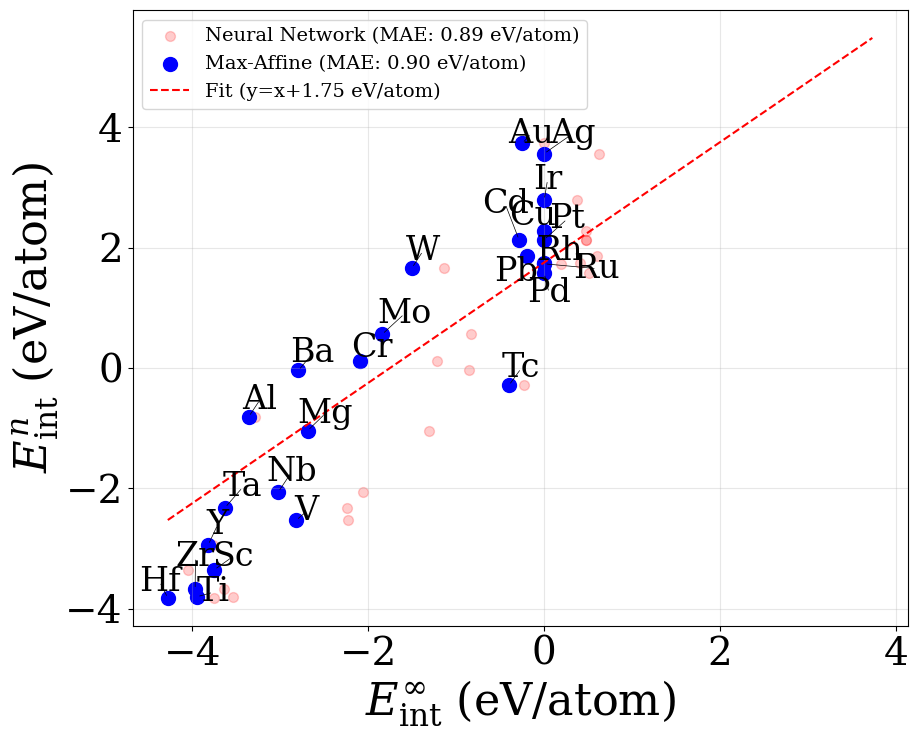

0.5284556613445281


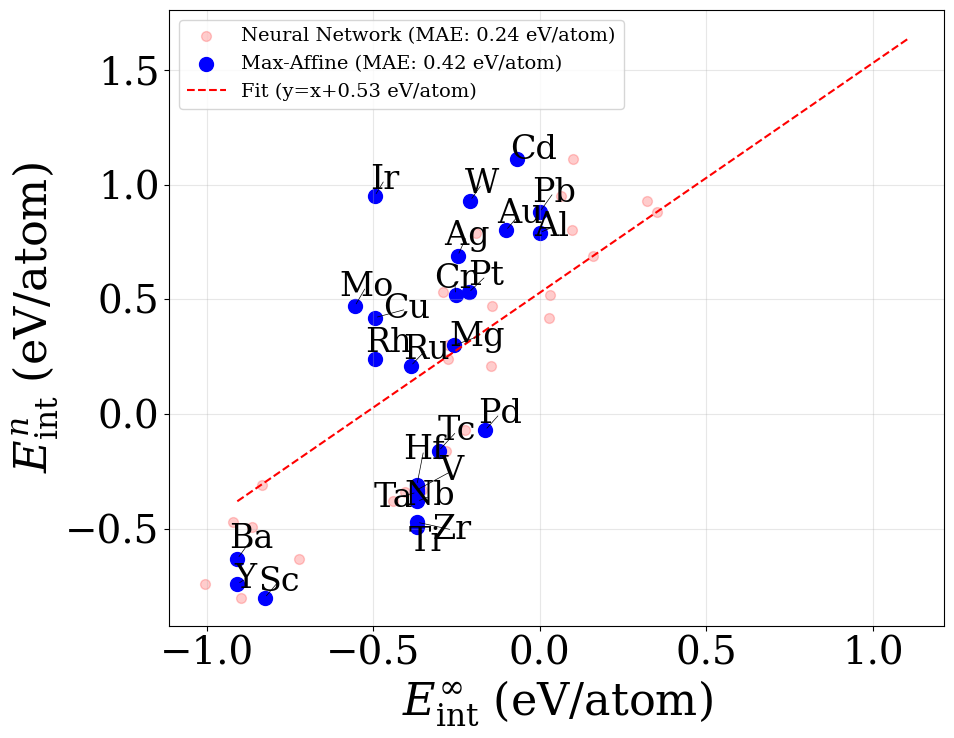

In [4]:
# Get interstitial energies of materials

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text  

# Convert the dictionary of NumPy arrays/lists into a dictionary of Torch tensors
p_dict_oh_t = {
    key: torch.tensor(value, dtype=torch.float32, device=device)
    for key, value in p_dict_oh.items()
}


def func(x, impurity, model, p_dict_oh_t):

    x_t = torch.tensor(x, dtype=torch.float32, device=device, requires_grad=True)

    E = model(x_t)
    
    grad_x = torch.autograd.grad(
        outputs=E,
        inputs=x_t,
        create_graph=False,
        retain_graph=False
    )[0]

    x_imp = p_dict_oh_t[impurity]

    res_t = ((x_imp - x_t) * grad_x).sum()

    return res_t.item()

def func_finite_diff(x0, x1, dx, model, p_dict_oh_t):
    """
    Computes:
       res = -dE/dImpurity + xfull . (dE/dxfull)
    but returns it as a *float* for the optimizer.

    Args:
        x (np.ndarray): shape (len(element_set),), the subset of parameters we optimize.
        impurity (string): element we substitute
        model (nn.Module): PyTorch model returning a scalar E.
        p_dict_oh_t (dict): e.g. {'O': one-hot Tensor, 'H': one-hot Tensor, ...}.

    Returns:
        float: The scalar value of res, detached from Torch.
    """
    # Convert x -> a Torch tensor for internal computation
    x_t0 = torch.tensor(x0, dtype=torch.float32, device=device, requires_grad=True)
    x_t1 = torch.tensor(x1, dtype=torch.float32, device=device, requires_grad=True)

    # 2) Forward pass -> E(xfull)  (should be a scalar)
    E0_pre = model(x_t0)
    E1_pre = model(x_t1)

    E0 = scaler_y.inverse_transform(E0_pre.detach().cpu().numpy().reshape(-1, 1))[0]
    E1 = scaler_y.inverse_transform(E1_pre.detach().cpu().numpy().reshape(-1, 1))[0]

    res_t = (E1 - E0) / dx

    # Return a Python float for the optimizer
    return res_t.item()


cris_elements = ['Nb', 'Al', 'Au', 'Pd', 'Pt', 'Ta', 'W', 'Mo', 'Cr', 'Ag', 'Ba', 'Cd', 'Cu', 'Hf', 'Ir', 'Mg', 'Pb', 'Rh', 'Ru', 'Sc', 'Tc', 'Ti', 'V', 'Y', 'Zr']
impurities = ['O', 'N', 'H']
ML_O_NN = []
ML_N_NN = []
ML_H_NN = []
ML_O_MA = []
ML_N_MA = []
ML_H_MA = []
dx=0.5
for cris_el in cris_elements:
    pure = cris_el
    impurity = 'O'
    x0 = np.array(p_dict_oh[pure])
    x1 = (1-dx) * np.array(p_dict_oh[pure]) + dx * np.array(p_dict_oh[impurity])
    # NN
    finite_diff_contrib = func_finite_diff(x0, x1, dx, NN, p_dict_oh_t)
    epure = combined_NN(torch.tensor(p_dict_oh[pure]))[0].item()
    eimpure = combined_NN(torch.tensor(p_dict_oh[impurity]))[0].item()
    ML_O_NN.append(epure-eimpure + finite_diff_contrib)
    # MA
    finite_diff_contrib = func_finite_diff(x0, x1, dx, MA, p_dict_oh_t)
    epure = combined_MA(torch.tensor(p_dict_oh[pure]))[0].item()
    eimpure = combined_MA(torch.tensor(p_dict_oh[impurity]))[0].item()
    ML_O_MA.append(epure-eimpure + finite_diff_contrib)
    
for cris_el in cris_elements:
    pure = cris_el
    impurity = 'N'
    x0 = np.array(p_dict_oh[pure])
    x1 = (1-dx) * np.array(p_dict_oh[pure]) + dx * np.array(p_dict_oh[impurity])
    # NN
    finite_diff_contrib = func_finite_diff(x0, x1, dx, NN, p_dict_oh_t)
    epure = combined_NN(torch.tensor(p_dict_oh[pure]))[0].item()
    eimpure = combined_NN(torch.tensor(p_dict_oh[impurity]))[0].item()
    ML_N_NN.append(epure-eimpure + finite_diff_contrib)
    # MA
    finite_diff_contrib = func_finite_diff(x0, x1, dx, MA, p_dict_oh_t)
    epure = combined_MA(torch.tensor(p_dict_oh[pure]))[0].item()
    eimpure = combined_MA(torch.tensor(p_dict_oh[impurity]))[0].item()
    ML_N_MA.append(epure-eimpure + finite_diff_contrib)

for cris_el in cris_elements:
    pure = cris_el
    impurity = 'H'
    x0 = np.array(p_dict_oh[pure])
    x1 = (1-dx) * np.array(p_dict_oh[pure]) + dx * np.array(p_dict_oh[impurity])
    # NN
    finite_diff_contrib = func_finite_diff(x0, x1, dx, NN, p_dict_oh_t)
    epure = combined_NN(torch.tensor(p_dict_oh[pure]))[0].item()
    eimpure = combined_NN(torch.tensor(p_dict_oh[impurity]))[0].item()
    ML_H_NN.append(epure-eimpure + finite_diff_contrib)
    # MA
    finite_diff_contrib = func_finite_diff(x0, x1, dx, MA, p_dict_oh_t)
    epure = combined_MA(torch.tensor(p_dict_oh[pure]))[0].item()
    eimpure = combined_MA(torch.tensor(p_dict_oh[impurity]))[0].item()
    ML_H_MA.append(epure-eimpure + finite_diff_contrib)


# Plot DFT vs Ml interstitial energies

# Data
DFT_O = [-4.05, -3.94, 0.64, 0.28, 1.17, -4.08, 0.38, -0.84, -1.08, 0.05, -4.61, -1.6, -0.22, -6.03, 1.77, -4.56, -1.91, 1.57, 0.77, -6.41, -1.24, -6.16, -4.57, -6.18, -6.08]
DFT_N = [-2.06, -0.81, 3.73, 1.57, 2.13, -2.32, 1.66, 0.56, 0.11, 3.56, -0.04, 2.13, 2.27, -3.82, 2.79, -1.04, 1.86, 1.74, 1.73, -3.35, -0.29, -3.8, -2.53, -2.94, -3.68]
DFT_H = [-0.38, 0.79, 0.80, -0.07, 0.53, -0.34, 0.93, 0.47, 0.52, 0.69, -0.63, 1.11, 0.42, -0.31, 0.95, 0.3, 0.88, 0.24, 0.21, -0.8, -0.16, -0.49, -0.33, -0.74, -0.47]

# Set global publication-quality settings
mpl.rcParams['font.family']    = 'serif'
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['font.size']      = 22
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

# Create a list with impurity data
# Each tuple contains: (impurity name, DFT values list, ML values list, color)
impurity_data_NN = [
    ('O', DFT_O, ML_O_NN, 'red'),
    ('N', DFT_N, ML_N_NN, 'red'),
    ('H', DFT_H, ML_H_NN, 'red'),
]
impurity_data_MA = [
    ('O', DFT_O, ML_O_MA, 'blue'),
    ('N', DFT_N, ML_N_MA, 'blue'),
    ('H', DFT_H, ML_H_MA, 'blue'),
]

# Loop over each impurity type and generate an independent plot
for imp_NN, imp_MA in zip(impurity_data_NN, impurity_data_MA):
    impurity, DFT_vals, ML_vals_NN, color_NN = imp_NN[0], imp_NN[1], imp_NN[2], imp_NN[3]
    _, _, ML_vals_MA, color_MA = imp_MA[0], imp_MA[1], imp_MA[2], imp_MA[3]
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Convert lists to NumPy arrays for computation
    DFT_arr = np.array(DFT_vals)
    ML_arr_NN  = np.array(ML_vals_NN)
    ML_arr_MA = np.array(ML_vals_MA)
    
    # Compute optimal shift (mean difference) and MAE for the current impurity type
    shift_NN = np.mean(ML_arr_NN - DFT_arr)
    shift_MA = np.mean(ML_arr_MA - DFT_arr)
    mae_NN   = np.mean(np.abs(DFT_arr + shift_NN - (ML_arr_NN)))
    mae_MA   = np.mean(np.abs(DFT_arr + shift_MA - (ML_arr_MA)))

    print(-shift_MA)
    
    # Determine axis limits based on the current data
    min_val = min(np.min(DFT_arr), np.min(ML_arr_MA))
    max_val = max(np.max(DFT_arr), np.max(ML_arr_MA))
    
    # Create the scatter plot for the current impurity
    ax.scatter(ML_vals_NN, DFT_vals, color=color_NN, s=50, alpha=0.2, label = f'Neural Network (MAE: {mae_NN:.2f} eV/atom)')
    ax.scatter(ML_vals_MA, DFT_vals, color=color_MA, s=100, label = f'Max-Affine (MAE: {mae_MA:.2f} eV/atom)')

    # Annotate each point with the corresponding element label; store texts to auto-adjust them
    texts = []
    for dft, ml, element in zip(DFT_vals, ML_vals_MA, cris_elements):
        txt = ax.text(ml, dft, element, fontsize=24, ha='left', va='bottom')
        texts.append(txt)
        
    # Automatically reposition text labels to reduce overlap
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
        force_points=1.5,    # strength of force from points
        force_text=1.5,      # strength of force between texts
        expand_points=(1.2, 1.4),  # extra margin from points
        expand_text=(1.2, 1.4),    # extra margin from text boxes
        only_move={'points':'y', 'text':'xy'},  # control movement directions
        lim=1000              # max number of iterations
    )
    
    # Plot the shifted perfect agreement line (slope-one line shifted vertically by the computed shift)
    ax.plot([min_val, max_val], [min_val - shift_MA, max_val - shift_MA],
            color='red', linestyle='--', label= f'Fit (y=x+{-shift_MA:.2f} eV/atom)')
    
    # Set axis labels, reference lines, and grid
    ax.set_ylabel(r'$E^{n}_{\mathrm{int}}\ \mathrm{(eV/atom)}$', fontsize=32)
    ax.set_xlabel(r'$E^{\infty}_{\mathrm{int}}\ \mathrm{(eV/atom)}$', fontsize=32)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.legend(fontsize=14, loc='upper left')
    plt.savefig(f'plots/MA-interstitial_{impurity}.png', dpi=300, bbox_inches='tight')
    plt.show()

y-intercept of fit line:  1.279977580183041
y-intercept of fit line:  0.6595722085940913


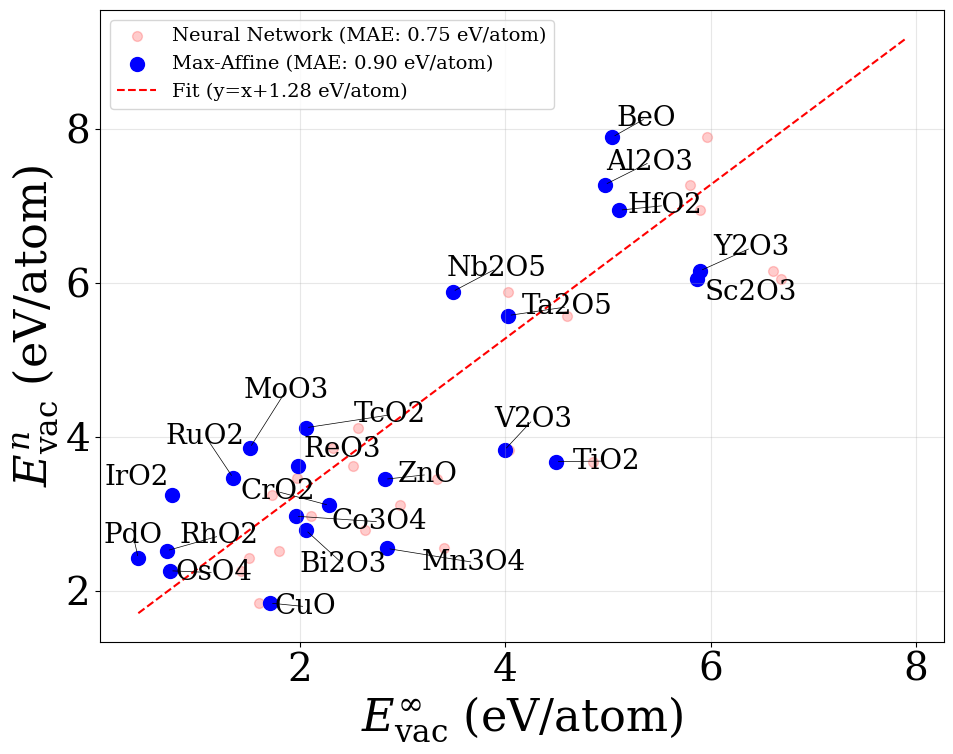

In [5]:
# Get substitutional energies of materials

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text  # Make sure to install adjustText via pip if you haven't already

# Set global publication-quality settings
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

# Convert the dictionary of NumPy arrays/lists into a dictionary of Torch tensors
p_dict_oh_t = {
    key: torch.tensor(value, dtype=torch.float32, device=device)
    for key, value in p_dict_oh.items()
}

sarvesh_oxides = ['Nb2O5', 'Ta2O5', 'MoO3', 'Al2O3', 'PdO', 'BeO',
                  'HfO2', 'V2O3', 'CrO2', 'IrO2', 'Co3O4', 'RhO2', 'Sc2O3', 'Y2O3', 'ReO3', 'TcO2', 'Bi2O3',
                  'RuO2', 'CuO', 'Mn3O4', 'TiO2', 'OsO4', 'ZnO']
sarvesh_oxide_elements = [['Nb', 'O'], ['Ta', 'O'], ['Mo', 'O'], ['Al', 'O'], ['Pd', 'O'], ['Be', 'O'],
                          ['Hf', 'O'], ['V', 'O'], ['Cr', 'O'], ['Ir', 'O'], ['Co', 'O'], ['Rh', 'O'], ['Sc', 'O'],
                         ['Y', 'O'], ['Re', 'O'], ['Tc', 'O'], ['Bi', 'O'], ['Ru', 'O'], ['Cu', 'O'], ['Mn', 'O'],
                         ['Ti', 'O'], ['Os', 'O'], ['Zn', 'O']]
sarvesh_oxide_concs = np.array([[2, 5], [2, 5], [1, 3], [2, 3], [1, 1], [1, 1],
                       [1, 2], [2, 3], [1, 2], [1, 2], [3, 4], [1, 2], [2, 3], [2, 3], [1, 3], [1, 2], [2, 3],
                       [1, 2], [1, 1], [3, 4], [1, 2], [1, 4], [1, 1]])
sarvesh_energies = np.array([5.89, 5.58, 3.86, 7.28, 2.42, 7.90,
                    6.95, 3.83, 3.11, 3.25, 2.97, 2.52, 6.05, 6.16, 3.62, 4.12, 2.79, 
                    3.47, 1.84, 2.55, 3.68, 2.26, 3.45])
# for i in range(len(sarvesh_oxide_elements)):
#     print(sarvesh_oxide_elements[i], sarvesh_energies[i])

sarvesh_oxide_concs_norm = sarvesh_oxide_concs / np.sum(sarvesh_oxide_concs, axis=1)[:, None]

import matplotlib as mpl

ML_energies_NN = []
ML_energies_MA = []
for (element_list, conc_list) in zip(sarvesh_oxide_elements, sarvesh_oxide_concs_norm):

    x_oxide = np.zeros_like(p_dict_oh['H'], dtype=float)
    for (el, conc) in zip(element_list, conc_list):
        x_oxide += conc * np.array(p_dict_oh[el])
    
    x_oxide_pdx = np.zeros_like(p_dict_oh['H'], dtype=float)
    x_oxide_mdx = np.zeros_like(p_dict_oh['H'], dtype=float)
    for (el, conc) in zip(element_list, conc_list):
        if el == 'O':
            sgn = +1
            conc_O = conc
        else:
            sgn = -1

        dx = 0.5
        x_oxide_pdx += (conc) * np.array(p_dict_oh[el])
        x_oxide_mdx += (conc - sgn * dx) * np.array(p_dict_oh[el])
        
    # Convert x -> a Torch tensor for internal computation
    x_0 = torch.tensor(x_oxide, dtype=torch.float32, device=device, requires_grad=False)
    x_p = torch.tensor(x_oxide_pdx, dtype=torch.float32, device=device, requires_grad=False)
    x_m = torch.tensor(x_oxide_mdx, dtype=torch.float32, device=device, requires_grad=False)

    # 2) Forward pass -> E(xfull)  (should be a scalar)
    E0 = combined_NN(x_0).item()
    Ep = combined_NN(x_p).item()
    Em = combined_NN(x_m).item()
    Epure = combined_NN(p_dict_oh_t['O']).item()

    ML_energies_NN.append(Epure - E0 - (1-conc_O) * (Ep - Em) / (dx))

    # 2) Forward pass -> E(xfull)  (should be a scalar)
    E0 = combined_MA(x_0).item()
    Ep = combined_MA(x_p).item()
    Em = combined_MA(x_m).item()
    Epure = combined_MA(p_dict_oh_t['O']).item()
    ML_energies_MA.append(Epure - E0 - (1-conc_O) * (Ep - Em) / (dx))


# Plot DFT vs Ml substitution energies

# Set global publication-quality settings
mpl.rcParams['font.family']    = 'serif'
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['font.size']      = 22
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

# DFT Data
DFT = sarvesh_energies

ML_energies_NN = np.array(ML_energies_NN)
ML_energies_MA = np.array(ML_energies_MA)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Compute intercept of best slope‑1 line
d_bar_MA = np.mean(np.array(DFT) - np.array(ML_energies_MA))
print("y-intercept of fit line: ", d_bar_MA)

# Compute intercept of best slope‑1 line
d_bar_NN = np.mean(np.array(DFT) - np.array(ML_energies_NN))
print("y-intercept of fit line: ", d_bar_NN)

# Range for plotting
xmin, xmax = min(DFT.min(), ML_energies_MA.min()), max(DFT.max(), ML_energies_MA.max())

# Compute MAE and add as a text box on the plot
mae_NN = np.mean(np.abs(ML_energies_NN + d_bar_NN - (DFT)))
mae_MA = np.mean(np.abs(ML_energies_MA + d_bar_MA - (DFT)))

ax.scatter(ML_energies_NN, DFT, color='red', s=50, alpha=0.2, label = f'Neural Network (MAE: {mae_NN:.2f} eV/atom)')
ax.scatter(ML_energies_MA, DFT, color='blue', s=100, label = f'Max-Affine (MAE: {mae_MA:.2f} eV/atom)')

# Plot the slope‑one best‑fit line
ax.plot([xmin, xmax], [xmin + d_bar_MA, xmax + d_bar_MA],
            color='red', linestyle='--', label= f'Fit (y=x+{d_bar_MA:.2f} eV/atom)')

# Create a list to store the text objects
texts = []
for dft, ml, element in zip(DFT, ML_energies_MA, sarvesh_oxides):
    txt = ax.text(ml, dft, element, fontsize=20, ha='left', va='bottom')
    texts.append(txt)

# Use adjust_text to automatically reposition the text labels to avoid overlapping
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
    force_points=3.5,    # strength of force from points
    force_text=2.5,      # strength of force between texts
    expand_points=(1.2, 1.4),  # extra margin from points
    expand_text=(1.2, 1.4),    # extra margin from text boxes
    only_move={'points':'y', 'text':'xy'},  # control movement directions
    lim=1000              # max number of iterations
)

# Label axes and add grid
ax.set_ylabel(r'$E^{n}_{\mathrm{vac}}\ \mathrm{(eV/atom)}$', fontsize=32)
ax.set_xlabel(r'$E^{\infty}_{\mathrm{vac}}\ \mathrm{(eV/atom)}$', fontsize=32)
# ax.set_xlim(1, xmax+1)
# ax.set_ylim(0, xmax+d_bar)
ax.grid(alpha=0.3)
ax.legend(fontsize=14)
# Set tick parameters for better visibility
ax.tick_params(axis='both', which='major', labelsize=28)

plt.tight_layout()
plt.savefig('plots/MA-vacancy.png', dpi=300, bbox_inches='tight')
plt.show()

NN
FePd: 0.0027780532836914062 eV/atom
NiPd: 0.011434555053710938 eV/atom
FeNi: 0.014212608337402344 eV/atom
FeCo: 0.06759023666381836 eV/atom
CoPd: 0.07036828994750977 eV/atom
CoNi: 0.0818028450012207 eV/atom
NiRh: 0.24677419662475586 eV/atom
PdRh: 0.2582087516784668 eV/atom
FeRh: 0.2609868049621582 eV/atom
CoRh: 0.32857704162597656 eV/atom
MA
FeCo: 0.0007276535034179688 eV/atom
CoNi: 0.057132720947265625 eV/atom
FeNi: 0.057860374450683594 eV/atom
NiPd: 0.1679549217224121 eV/atom
CoPd: 0.22508764266967773 eV/atom
FePd: 0.2258152961730957 eV/atom
FeRh: 0.3012399673461914 eV/atom
CoRh: 0.3019676208496094 eV/atom
NiRh: 0.359100341796875 eV/atom
PdRh: 0.5270552635192871 eV/atom
Max intensities: Co=1.0, Fe=1.0, Ni=1.0, Pd=1.0, Rh=1.0, P=1.0
CoNi  IoU=0.0644  Dice=0.1209
FeCo  IoU=0.0590  Dice=0.1115
FeNi  IoU=0.0529  Dice=0.1005
CoPd  IoU=0.0505  Dice=0.0961
PdRh  IoU=0.0500  Dice=0.0953
NiPd  IoU=0.0492  Dice=0.0938
NiRh  IoU=0.0419  Dice=0.0804
CoRh  IoU=0.0407  Dice=0.0782
FeRh  IoU=0.0

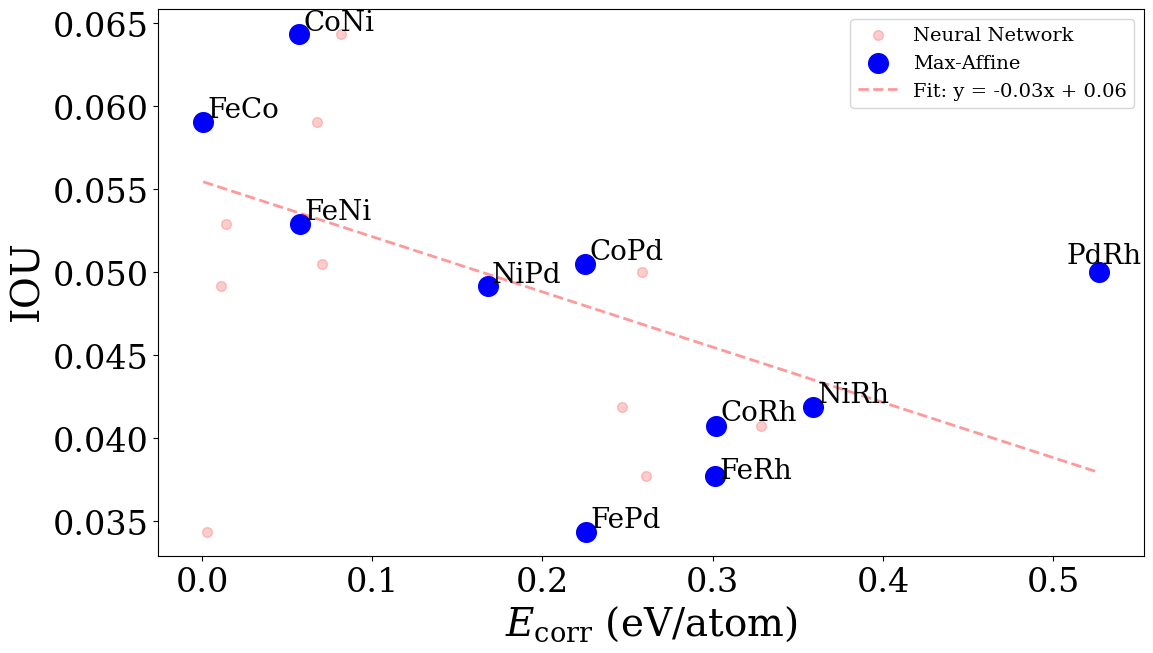

In [6]:

elems = ['Fe', 'Co', 'Ni', 'Pd', 'Rh']

def MP_en_fd_3(M1, M2, x_list, x, y, combined_model):
    energies = []
    for delta in x_list:
        # in1 = x*delta * p_dict_oh_t[M1] + y*(1-delta) * p_dict_oh_t[M2] + ((1-x)*delta+(1-y)*(1-delta)) * p_dict_oh_t['P']
        in1 = 2/3*delta * p_dict_oh_t[M1] + 2/3*(1-delta) * p_dict_oh_t[M2] + 1/3 * p_dict_oh_t['P']
        energies.append(combined_model(in1).item())
    slope = abs(energies[-1] - energies[0])
    return slope

En_diff_list_NN = []
En_diff_list_MA = []
binary_metals_list = []
x_vector = np.linspace(0, 1, 101)
for i, M1 in enumerate(elems):
    for j, M2 in enumerate(elems):
        if j > i:
            efd_NN = MP_en_fd_3(M1, M2, x_vector, None, None, combined_NN)
            En_diff_list_NN.append(efd_NN)
            efd_MA = MP_en_fd_3(M1, M2, x_vector, None, None, combined_MA)
            En_diff_list_MA.append(efd_MA)
            binary_metals_list.append(f'{M1}{M2}')

# Get the sorting indices of En_diff_list
sorting_indices_NN = sorted(range(len(En_diff_list_NN)), key=lambda i: En_diff_list_NN[i])
sorting_indices_MA = sorted(range(len(En_diff_list_MA)), key=lambda i: En_diff_list_MA[i])

# Sort binary_metals_list using the same indices
sorted_binary_metals_list_NN = [binary_metals_list[i] for i in sorting_indices_NN]
sorted_binary_metals_list_MA = [binary_metals_list[i] for i in sorting_indices_MA]

sorted_En_diff_list_NN = sorted(En_diff_list_NN)
sorted_En_diff_list_MA = sorted(En_diff_list_MA)

print('NN')
for i in range(len(sorted_En_diff_list_NN)):
    print(f'{sorted_binary_metals_list_NN[i]}: {sorted_En_diff_list_NN[i]} eV/atom')
print('MA')
for i in range(len(sorted_En_diff_list_MA)):
    print(f'{sorted_binary_metals_list_MA[i]}: {sorted_En_diff_list_MA[i]} eV/atom')


from PIL import Image, ImageFilter
import numpy as np

# --- load + slight blur (less sensitive to pixel alignment) ---
img_Co = Image.open("HEP_images/Co.png")#.filter(ImageFilter.GaussianBlur(radius=3))
img_Fe = Image.open("HEP_images/Fe.png")#.filter(ImageFilter.GaussianBlur(radius=3))
img_Ni = Image.open("HEP_images/Ni.png")#.filter(ImageFilter.GaussianBlur(radius=3))
img_Pd = Image.open("HEP_images/Pd.png")#.filter(ImageFilter.GaussianBlur(radius=3))
img_Rh = Image.open("HEP_images/Rh.png")#.filter(ImageFilter.GaussianBlur(radius=3))
img_P =  Image.open("HEP_images/P.png" )#.filter(ImageFilter.GaussianBlur(radius=3))

# --- to float [0,1], crop exactly as you did, drop alpha if present ---
lower = 450
upper = -450
arr_Co = np.asarray(img_Co, dtype=np.float32)[:lower,upper:,:3] / 255.0
arr_Fe = np.asarray(img_Fe, dtype=np.float32)[:lower,upper:,:3] / 255.0
arr_Ni = np.asarray(img_Ni, dtype=np.float32)[:lower,upper:,:3] / 255.0
arr_Pd = np.asarray(img_Pd, dtype=np.float32)[:lower,upper:,:3] / 255.0
arr_Rh = np.asarray(img_Rh, dtype=np.float32)[:lower,upper:,:3] / 255.0
arr_P =  np.asarray(img_P,  dtype=np.float32)[:lower,upper:,:3] / 255.0

# --- collapse to a single intensity per pixel, then binarize to material/not-material ---
# use channel-max as you did; threshold can be tuned (e.g., 0.2)
max_Co = np.max(np.max(arr_Co, axis=2).flatten())
max_Fe = np.max(np.max(arr_Fe, axis=2).flatten())
max_Ni = np.max(np.max(arr_Ni, axis=2).flatten())
max_Pd = np.max(np.max(arr_Pd, axis=2).flatten())
max_Rh = np.max(np.max(arr_Rh, axis=2).flatten())
max_P = np.max(np.max(arr_P, axis=2).flatten())
print(f'Max intensities: Co={max_Co}, Fe={max_Fe}, Ni={max_Ni}, Pd={max_Pd}, Rh={max_Rh}, P={max_P}')
thresh = 0.5
Co = (np.max(arr_Co, axis=2)/max_Co > thresh).astype(np.uint8).flatten()
Fe = (np.max(arr_Fe, axis=2)/max_Fe > thresh).astype(np.uint8).flatten()
Ni = (np.max(arr_Ni, axis=2)/max_Ni > thresh).astype(np.uint8).flatten()
Pd = (np.max(arr_Pd, axis=2)/max_Pd > thresh).astype(np.uint8).flatten()
Rh = (np.max(arr_Rh, axis=2)/max_Rh > thresh).astype(np.uint8).flatten()

# --- only compare where any material exists in either of the two images being compared ---
def iou(a, b):
    inter = np.logical_and(a, b)
    union = np.logical_or(a, b)
    u = union.sum()
    return (inter.sum() / u) if u > 0 else 0.0

def dice(a, b):
    inter = np.logical_and(a, b).sum()
    s = a.sum() + b.sum()
    return (2.0 * inter / s) if s > 0 else 0.0

pairs = {
    'FeCo': (Co, Fe),
    'CoNi': (Co, Ni),     # was 'NiCo'
    'CoPd': (Co, Pd),
    'CoRh': (Co, Rh),
    'FeNi': (Fe, Ni),
    'FePd': (Fe, Pd),
    'FeRh': (Fe, Rh),
    'NiPd': (Ni, Pd),
    'NiRh': (Ni, Rh),
    'PdRh': (Pd, Rh),     # was 'RhPd'
}

results = []
for name, (a, b) in pairs.items():
    results.append((name, iou(a, b), dice(a, b)))

# sort by IoU (Jaccard) descending and print (you can print Dice too)
for name, j, d in sorted(results, key=lambda t: t[1], reverse=True):
    print(f'{name}  IoU={j:.4f}  Dice={d:.4f}')

correlations_and_energies_NN = []
correlations_and_energies_MA = []
for i,name in enumerate(sorted_binary_metals_list_NN):
    for result in results:
        if name == result[0]:
            correlations_and_energies_NN.append((result[1], sorted_En_diff_list_NN[i]))
for i,name in enumerate(sorted_binary_metals_list_MA):
    for result in results:
        if name == result[0]:
            correlations_and_energies_MA.append((result[1], sorted_En_diff_list_MA[i]))

correlations_and_energies_NN = np.array(correlations_and_energies_NN)
correlations_and_energies_MA = np.array(correlations_and_energies_MA)

import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

x = np.arange(len(sorted_En_diff_list_NN))

# 1) Make a big figure
fig, ax = plt.subplots(figsize=(12, 7))
texts = []
nn_labeled = False
for corr_en, lbl in zip(correlations_and_energies_NN, sorted_binary_metals_list_NN):
    ax.scatter(corr_en[1], corr_en[0], s=50, color='red',
               alpha=0.2, label=None if nn_labeled else 'Neural Network')
    nn_labeled = True

ma_labeled = False
for corr_en, lbl in zip(correlations_and_energies_MA, sorted_binary_metals_list_MA):
    ax.scatter(corr_en[1], corr_en[0], s=200, color='blue',
               label=None if ma_labeled else 'Max-Affine')
    ma_labeled = True
    texts.append(ax.text(corr_en[1], corr_en[0], lbl, fontsize=20))

# Extract your x and y values from correlations_and_energies
ydata = np.array([pt[0] for pt in correlations_and_energies_MA])
xdata = np.array([pt[1] for pt in correlations_and_energies_MA])

# Use adjust_text to automatically reposition the text labels to avoid overlapping
adjust_text(
    texts,
    force_points=1.0,    # strength of force from points
    force_text=1.0,      # strength of force between texts
    expand_points=(1.1, 1.1),  # extra margin from points
    expand_text=(1.1, 1.1),    # extra margin from text boxes
    lim=1000              # max number of iterations
)

# finalize styling
ax.set_ylabel(r'$\mathrm{IOU}$', fontsize=28)
ax.set_xlabel(r'$E_{\mathrm{corr}}$ (eV/atom)', fontsize=28)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

# Fit a first-degree polynomial (linear fit)
m, b = np.polyfit(xdata, ydata, 1)

# Generate a smooth line across the range of your xdata
x_line = np.linspace(np.min(xdata), np.max(xdata), 200)
y_line = m * x_line + b

# Plot the fit line on top of your scatter
ax.plot(x_line, y_line, color="red", linewidth=2, label=f"Fit: y = {m:.2f}x + {b:.2f}", alpha=0.4, linestyle='--')
ax.legend(fontsize=14)
fig.tight_layout()
plt.savefig('plots/HEP-correlations.png', dpi=300)
plt.show()